# AGENTES 
La idea es utilizar un LLM para tomar una serie de acciones, en este caso el LLM se convierte en una herramienta capaz de razonar y decidir en que orden se llevan a cabo las acciones para llegar a un resultado. 

Desde mi punto de vista todo inicia con la publicación del artículo ReAct: Synergizing reasoning and acting in language models
[ReAct](https://arxiv.org/abs/2210.03629). Con la utilización de ReAct podemos reducir la probabilidad de que el modelo alucine.

ReAct combinando la posibilidad de razonar y actuar permite a los modelos razonar de forma dinamica para crear, mantener o ajustar planes de accion mientras se interactua con entornos externos como sitios web, documentos, bases de datos, apis entre otros.  

## Aprendizaje en contexto (in-context learning)

1. zero-shot learning: proveemos a nuestro LLM un prompt que puede incluir algo de información previa antes de proveer una pregunta o comando, con esto ayudamos al LLM a encontrar una buena respuesta.
   
2. few-shot learning: proveemos a nuestro LLM uno o varios ejemplos de prompts y respuestas deseadas. Cuando se pasa una nueva pregunta o comando el LLM va a responder teniendo en cuenta los ejemplos. 

In [1]:
import json
import os
import sys
import boto3
from langchain.agents import load_tools
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType
from langchain.llms.bedrock import Bedrock
from langchain.prompts import PromptTemplate
from langchain import LLMChain
from langchain.utilities import SerpAPIWrapper

In [3]:
model_parameters = {"temperature": 0.0, "top_p": .5, "max_tokens_to_sample": 2000}

In [4]:
react_agent_llm = Bedrock(
    model_id="anthropic.claude-instant-v1", 
    model_kwargs=model_parameters,
    credentials_profile_name="default", 
    region_name="us-east-1"
)
idea_llm = Bedrock(
    model_id="anthropic.claude-instant-v1",
    model_kwargs={"temperature":0,"stop_sequences" : ["```output"]},
    credentials_profile_name="default",
    region_name="us-east-1"
)

In [5]:
# this tool helps send parameters to lambda functions 
# TODO include the env variable 
tools = load_tools(
    ["awslambda"],
    awslambda_tool_name="email-delivery",
    awslambda_tool_description="sends an email with the specified content to restebance@gmail.com",
    function_name="agentIntegrationToolLambdaTest",
    llm=react_agent_llm
)

In [7]:
template = """
Human: Given a product idea, generate a single idea for a influencer marketing campaign for the product idea to attract customers and decrease cost per click.
```text
${{single idea for influencer marketing campaign}}
```

Assistant:
 Here is an example response with a single idea for the influecer marketing campaign for the product idea 'Conversational Agent for booking flights':
```
Partner with travel influencers and have them demonstrate booking a flight through a video. They can walk viewers through finding the best deals, comparing options, and completing the booking via conversation. This shows how easy and convenient it is.
```

Human: {product_idea}

Assistant:"""

prompt = PromptTemplate(template=template, input_variables=["product_idea"])
llm_chain = LLMChain(prompt=prompt, llm=idea_llm)

tools.append(
    Tool.from_function(
        func=llm_chain.run,
        name="Ideagenerator",
        description="Useful for when you need generate ideas for influencer marketing campaigns for your product idea.",
    )
)
# llm_chain.predict(product_idea="ultimate beer")

In [10]:
react_agent = initialize_agent(
    tools,
    react_agent_llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    return_intermediate_steps=True,
    handle_parsing_errors=True                            
)

In [11]:
prompt_template = """Use the following format:
Question: the input question you must answer
Thought: you should always think about what to do, Also try to follow steps mentioned above
Action: the action to take, should be one of [Ideagenerator"]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Question: {input}

Assistant:
{agent_scratchpad}"""

In [12]:
react_agent.agent.llm_chain.prompt.template=prompt_template

In [13]:
question = "What would be a really good marketing campaign for my idea: 'coffee shop in Medellín Colombia', I would like to talk with influencers"

In [14]:
react_agent(question)



> Entering new AgentExecutor chain...
 Here is a suggested marketing campaign in the requested format:

Question: What would be a really good marketing campaign for my idea: 'coffee shop in Medellín Colombia', I would like to talk with influencers

Thought: I should brainstorm different marketing ideas and target audiences.

Action: Ideagenerator
Action Input: coffee shop marketing campaign influencers Medellin Colombia

Observation:  Here is a sample influencer marketing campaign idea for a coffee shop in Medellin, Colombia:

Partner with local lifestyle and food influencers in Medellin to promote the coffee shop. Identify 5-10 influencers with audiences interested in coffee, food, and day-to-day life in Medellin. 

Send the influencers complimentary coffee and pastries from the shop for a week. Ask them to post daily on their Instagram Stories about their experience at the coffee shop - what drinks and foods they enjoyed, the atmosphere, any local characters they met, etc. 

Provid

{'input': "What would be a really good marketing campaign for my idea: 'coffee shop in Medellín Colombia', I would like to talk with influencers",
 'output': 'Partnering with local lifestyle and food influencers in Medellin through a complimentary sampling campaign and ongoing discounts seems like it could be a really effective low-cost marketing strategy for a new coffee shop to help build awareness and a customer base among their target audiences.',
 'intermediate_steps': [(AgentAction(tool='Ideagenerator', tool_input='coffee shop marketing campaign influencers Medellin Colombia\n', log=" Here is a suggested marketing campaign in the requested format:\n\nQuestion: What would be a really good marketing campaign for my idea: 'coffee shop in Medellín Colombia', I would like to talk with influencers\n\nThought: I should brainstorm different marketing ideas and target audiences.\n\nAction: Ideagenerator\nAction Input: coffee shop marketing campaign influencers Medellin Colombia\n"),
   " 

# NOTAS
Vaya, eso no lo esperabamos.
Tan solo le pregunte por medio del agente sobre una idea para la campaña, pero nunca le dije que redactara un correo para enviar a los posibles Influencers. 
Solo con especificar la herramienta "email-delivery" continuo con el proceso. Aqui puede verse el log de invocación de la función lambda (que menos mal no realiza ninguna acción concreta)

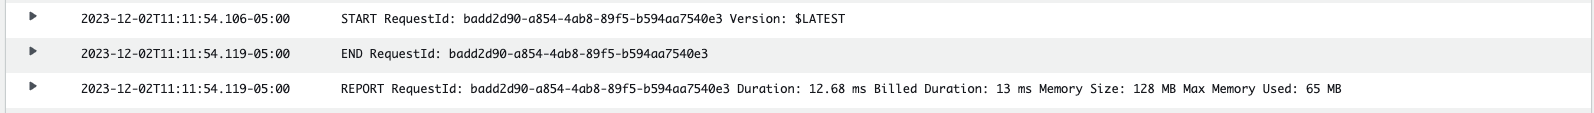